In [1]:
import torch
from torchinfo import summary
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from piq import psnr, ssim, brisque, LPIPS
from torchvision.transforms import Resize

from utils.metrics import validation_scores
from models.prediction.AE import AE
from utils.datasets import CIFAR_SR


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
num_epochs = 17
batch_size = 512
scalefactor = 4
latent_dims = [64]
channels = [32, 64, 128, 256]
in_channels = 3
base_width = 32 // scalefactor
model = AE(in_channels=in_channels,
                          latent_dims=latent_dims,
                          channels=channels,
                          base_width=base_width
                          ).to(device)
print(model.sample(torch.randn(1, in_channels, base_width, base_width).to(device)).shape)
summary(model, input_size=(1, in_channels, base_width, base_width))

torch.Size([1, 3, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
AE                                       [1, 3, 32, 32]            --
├─AELREncoder: 1-1                       [1, 64]                   --
│    └─Conv2d: 2-1                       [1, 32, 8, 8]             128
│    └─Conv2d: 2-2                       [1, 64, 4, 4]             32,832
│    └─Conv2d: 2-3                       [1, 128, 2, 2]            131,200
│    └─Linear: 2-4                       [1, 64]                   32,832
├─AEDecoder: 1-2                         [1, 3, 32, 32]            --
│    └─Linear: 2-5                       [1, 4096]                 266,240
│    └─ConvTranspose2d: 2-6              [1, 128, 8, 8]            524,416
│    └─ConvTranspose2d: 2-7              [1, 64, 16, 16]           131,136
│    └─ConvTranspose2d: 2-8              [1, 32, 32, 32]           32,800
│    └─Conv2d: 2-9                       [1, 3, 32, 32]            99
Total params: 1,151,683
Trainable params: 1,151,683


In [3]:
train_dataset = CIFAR_SR(scale_factor=scalefactor, split='train')
test_dataset = CIFAR_SR(scale_factor=scalefactor, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_train_data = len(train_dataset)
print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(test_dataset)} validation samples")

Dataset Loaded: 50000 training samples, 10000 validation samples


In [4]:
# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

In [5]:
val_HR, val_LR = test_dataset.get_samples(1000)
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    val_total_loss = 0

    for HR, LR in train_loader:

        optimizer.zero_grad()

        recon_imgs = model(LR)

        loss = -ssim(recon_imgs, HR)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_recon_imgs = model(val_LR)
            val_loss = -ssim(val_recon_imgs, val_HR)
            val_total_loss += val_loss.item()

        total_loss += loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.2f}")
    print(f"Validation Loss: {val_total_loss:.2f}")
    model.loss.append(total_loss)
    val_losses.append(val_total_loss)


Epoch [1/17] | Loss: -33.53
Validation Loss: -34.12
Epoch [2/17] | Loss: -51.28
Validation Loss: -51.72
Epoch [3/17] | Loss: -56.51
Validation Loss: -56.82
Epoch [4/17] | Loss: -59.44
Validation Loss: -59.57
Epoch [5/17] | Loss: -60.99
Validation Loss: -60.99
Epoch [6/17] | Loss: -61.82
Validation Loss: -61.68
Epoch [7/17] | Loss: -62.61
Validation Loss: -62.35
Epoch [8/17] | Loss: -63.14
Validation Loss: -62.77
Epoch [9/17] | Loss: -63.54
Validation Loss: -63.05
Epoch [10/17] | Loss: -63.81
Validation Loss: -63.18
Epoch [11/17] | Loss: -64.08
Validation Loss: -63.31
Epoch [12/17] | Loss: -64.29
Validation Loss: -63.43
Epoch [13/17] | Loss: -64.63
Validation Loss: -63.61
Epoch [14/17] | Loss: -64.81
Validation Loss: -63.64
Epoch [15/17] | Loss: -64.96
Validation Loss: -63.66
Epoch [16/17] | Loss: -65.16
Validation Loss: -63.70
Epoch [17/17] | Loss: -65.27
Validation Loss: -63.69


[]

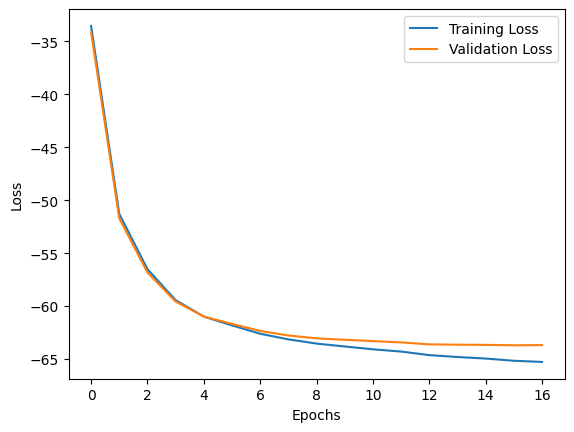

In [12]:
plt.plot(model.loss, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [13]:
HR, LR = test_dataset.get_samples(1000)
SR = model.sample(LR)

In [14]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

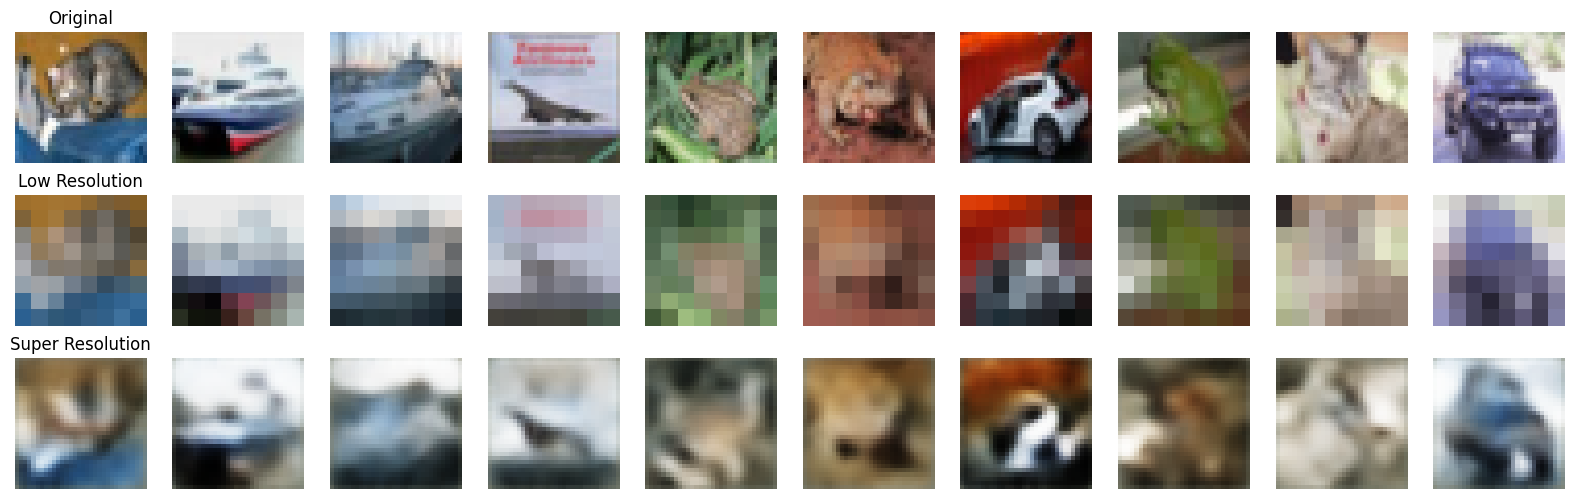

In [15]:
show_image(HR, LR, SR, 10)

In [16]:
mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("MSE", mse_val)
print("Perceptual:", perceptual_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

MSE 0.011815221980214119
Perceptual: 5.251286029815674
PSNR: 19.759437561035156
SSIM: 0.6502042412757874
LPIPS: 0.4490657150745392
BRISQUE: 88.2747573852539
PSNR Consistency: 25.570470809936523
MSE Diversity: 1.2203384009390939e-16
LPIPS Diversity: 6.330865018725244e-12


In [11]:
#torch.save(model.state_dict(), "AE_CIFAR_4x_prediction_mse.pth")